# Instructions
In `dibecs_3.3.0` run
+ `conda install -c conda-forge python-graphviz`
+ `pip install pydot "pymc3>=3.11" "calibr8>=5.0.3"`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [17]:
import ipywidgets
import pandas
import pathlib
import numpy
from matplotlib import cm, pyplot

import pymc3
import arviz
import theano.tensor as tt
import xarray

import retl
import calibr8
import robotools

import model
import helper

import theano
theano.gof = theano.graph
theano.gof.graph = theano.graph.basic

print(f"pymc {pymc3.__version__}")
print(f"calibr8 {calibr8.__version__}")

pymc 3.11.0
calibr8 5.0.2


In [6]:
DP_RUN = pathlib.Path(r"X:\CM\Pahpshmir_BL-sGFP-Cutinase-BSI\9REA8P")
DP_RESULTS = pathlib.Path("9REA8P_Results")
DP_RESULTS.mkdir(exist_ok=True)

In [32]:
# construct a DataFrame of cutinase concentration factors in the "standards"
# the standards were located in columns [1-3] of the "samples" DWP
# they were copied into [4-6] within the "samples" DWP
# and again copied into [7-12] of the assay plate
plan = robotools.DilutionPlan(
    xmin=0.01, xmax=1,
    R=8, C=3,
    stock=1,
    mode="log",
    vmax=950,
    min_transfer=30
)

df_inputs = pandas.DataFrame(
    columns=["input_well", "type", "concentration_factor"]
).set_index("input_well")
for ir, r in enumerate("ABCDEFGH"):
    for ic, c in enumerate([1,2,3,4,5,6]):
        #df_inputs.loc[f"{r}{c:02d}", "type"] = f"ref{r}{ic % 3 + 1:02d}"
        df_inputs.loc[f"{r}{c:02d}", "type"] = f"reference"
        df_inputs.loc[f"{r}{c:02d}", "concentration_factor"] = plan.x[ir, ic % 3]

        
df_inputs.head()

,type,concentration_factor
input_well,,
A01,reference,1.0
A02,reference,0.201053
A03,reference,0.041053
A04,reference,1.0
A05,reference,0.201053


In [57]:
# mock as if there were not only reference samples, but also two "samples"
# → "mock_one" in B01 and 2x diluted in C01
# → "mock_two" in D01
df_inputs.loc[["B01"], ["type", "concentration_factor"]] = ("mock_one", 1)
df_inputs.loc[["C01"], ["type", "concentration_factor"]] = ("mock_one", 0.5)
df_inputs.loc[["D01"], ["type", "concentration_factor"]] = ("mock_two", 1)
df_inputs.head(n=8)

,type,concentration_factor
input_well,,
A01,reference,1.0
A02,reference,0.201053
A03,reference,0.041053
A04,reference,1.0
A05,reference,0.201053
A06,reference,0.041053
B01,mock_one,1
B02,reference,0.165263


In [58]:
# read the assay results
df_time, df_samples, t_obs, y_obs = helper.read_cutinase(DP_RUN, df_inputs.index)
df_sGFP, t0_delta = helper.read_gfp(DP_RUN)
em_nitrophenol = model.NitrophenolAbsorbanceModel.load(pathlib.Path(DP_RESULTS, "9REA8P_em_nitrophenol.json"))

The MTP was pipetted at 2020-11-19 18:43:11+00:00 (0.958 hours before the end of the first measurement).
!! Overriding t0_delta with 0.25 hours !!


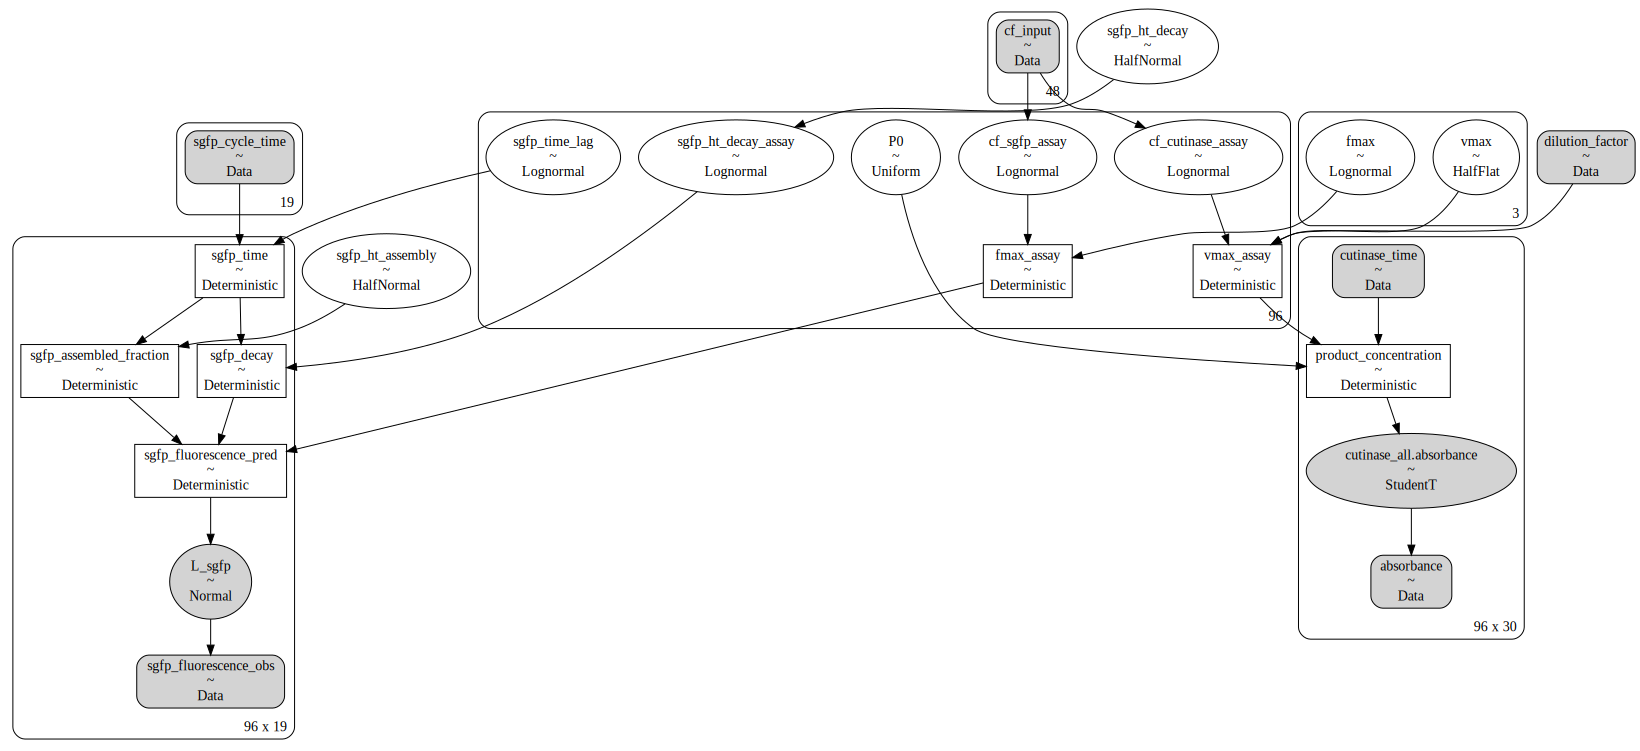

In [59]:
# create the model to describe sGFP and cutinase assay for all samples at the same time
with pymc3.Model() as pmodel:
    type_indices = helper.model_concentrations(df_inputs)
    helper.model_cutinase(t_obs, y_obs, em_nitrophenol, type_indices)
    helper.model_sgfp(df_sGFP, t0_delta, type_indices)
pymc3.model_to_graphviz(pmodel)

In [63]:
# the model has "coords" that contain information about the samples & wells:
helper.print_coords(pmodel.coords)

type                (3,)	mock_one, mock_two, reference
input_well          (48,)	A01, A02, A03, …, H06
assay_well          (96,)	A01, A02, A03, …, H12
cutinase_cycle      (30,)	0, 1, 2, …, 29
sgfp_cycle          (19,)	0, 1, 2, …, 18


In [64]:
with pmodel:
    idata = pymc3.sample(return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sgfp_ht_decay_assay, sgfp_ht_decay, sgfp_ht_assembly, fmax, sgfp_time_lag, P0, vmax, cf_sgfp_assay, cf_cutinase_assay]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 377 seconds.


0, dim: assay_well, 96 =? 96
1, dim: sgfp_cycle, 19 =? 19


The number of effective samples is smaller than 25% for some parameters.


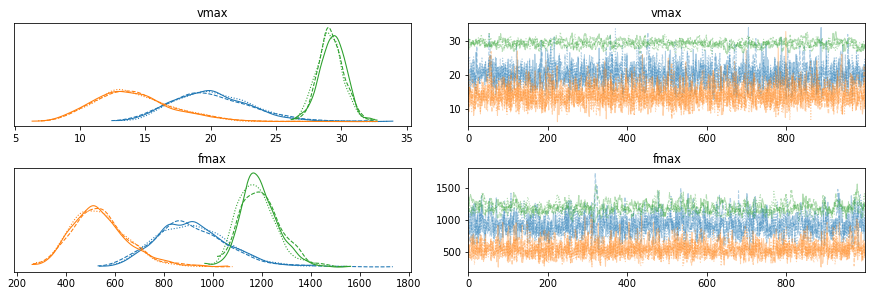

In [65]:
arviz.plot_trace(
    idata,
    var_names=[
        "vmax", "fmax",
    ],
    compact=True
);

In [67]:
def plot_gfp_fit(type: str, input_well: str):
    # derived from inputs:
    assay_wells = helper.replicate_wells([input_well])

    # local vars to make code more readable:
    posterior = idata.posterior.stack(sample=("chain", "draw"))
    fmax = posterior.fmax.sel(type=type)
    cf_input = idata.constant_data.cf_input.sel(input_well=input_well)
    
    # figure constraints
    x_min = min(idata.constant_data.sgfp_cycle_time.values)
    x_max = max(idata.constant_data.sgfp_cycle_time.values)
    x_center = (x_min + x_max) / 2
    
    fig, axs = pyplot.subplots(dpi=140, nrows=2, ncols=2, figsize=(12, 6), sharey="row", sharex="col", squeeze=False)

    for c, assay_well in enumerate(assay_wells):
        fmax_input = fmax * cf_input
        fmax_assay = posterior.fmax_assay.sel(assay_well=assay_well)
        sgfp_assembled_fraction = posterior.sgfp_assembled_fraction.sel(assay_well=assay_well)
        f_no_decay = fmax_assay * sgfp_assembled_fraction

        # limit in the input well
        pymc3.gp.util.plot_gp_dist(
            ax=axs[0, c],
            samples=numpy.array([fmax_input.values]*2).T,
            x=numpy.array([x_min, x_center]),
            samples_alpha=0,
            palette="Greys",
        )
        # limit in the assay well (without decay, t->∞)
        pymc3.gp.util.plot_gp_dist(
            ax=axs[0, c],
            samples=numpy.array([fmax_assay.values]*2).T,
            x=numpy.array([x_center, x_max]),
            samples_alpha=0,
            palette="Blues",
        )

        # fluorescence curve if there was no decay
        pymc3.gp.util.plot_gp_dist(
            ax=axs[0, c],
            samples=f_no_decay.values,
            x=idata.constant_data.sgfp_cycle_time.values,
            samples_alpha=0,
            palette="Greens",
        )

        # and the actual fluorescence
        pymc3.gp.util.plot_gp_dist(
            ax=axs[0, c],
            samples=posterior.sgfp_fluorescence_pred.sel(assay_well=assay_well).values.T,
            x=idata.constant_data.sgfp_cycle_time.values,
            samples_alpha=0,
        )
        axs[0, c].scatter(
            idata.constant_data.sgfp_cycle_time.values,
            idata.constant_data.sgfp_fluorescence_obs.sel(assay_well=assay_well),
            marker="x",
        )

        # residuals for the fluorescence
        samples = posterior.sgfp_fluorescence_pred.sel(assay_well=assay_well)
        median = samples.median("sample").values.T
        data = idata.constant_data.sgfp_fluorescence_obs.sel(assay_well=assay_well)
        rel_residuals = ((data - median) / median * 100).values
        
        pymc3.gp.util.plot_gp_dist(
            ax=axs[1, c],
            samples=(samples.values.T - median) / median * 100,
            x=idata.constant_data.sgfp_cycle_time.values,
            samples_alpha=0,
        )
        axs[1, c].scatter(idata.constant_data.sgfp_cycle_time.values, rel_residuals, marker="x")
        axs[0, c].set_title(f"assay well {assay_well}")
        axs[1, c].set_xlabel("time   [h]")
    axs[0, 0].set_ylim(0)
    axs[0, 0].set_ylabel(
        "fluorescence\n"
        "in input well (grey)\n"
        "in assay well (blue)\n"
        "without decay (green)\n"
        "observed (red)"
    )
    axs[1, 0].set_ylim(-numpy.ptp(rel_residuals), numpy.ptp(rel_residuals))
    axs[1, 0].set_ylabel("residual   [%]")
    fig.suptitle(f"Model fit to '{type}' replicates from input well {input_well}", y=1.01)
    fig.tight_layout()
    pyplot.show()

ipywidgets.interact(
    plot_gfp_fit,
    type=idata.posterior.type.values,
    input_well=idata.constant_data.input_well.values,
);

interactive(children=(Dropdown(description='type', options=('mock_one', 'mock_two', 'reference'), value='mock_…